In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader,Subset
import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

<ipython-input-1-b2df4b64a75a>:10: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


In [2]:
device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


In [3]:
# transformations
transform = T.Compose([ T.ToTensor(),
                        T.Normalize([.5,.5,.5],[.5,.5,.5])
                       ])
'''

z-score normalization
subtracting mean of each pixel and dividing by std
will place the mean to 0 and make the values closer to the mean each pixel value higher than the mean will be +ve and lower will be -ve
--
 Standard deviation is a measure of the dispersion or spread of a set of values. It quantifies how much the values in a dataset vary around the mean (average) value.
---
T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the image



 The T.Normalize transformation is applied element-wise, meaning it normalizes each channel of the input tensor independently. The parameters passed to T.Normalize are the means and standard deviations for each channel of the input tensor. In your case, the means for each channel are [0.5, 0.5, 0.5], and the standard deviations for each channel are also [0.5, 0.5, 0.5].

The normalization formula applied to each channel of the input tensor is:

output[channel]=(input[channel]−mean[channel])/std[channel]

​


In this case, the mean is
0.5
0.5 and the standard deviation is also
0.5
0.5 for each channel. This means that each channel's values are scaled to be in the range

[−1,1]
'''
# import the data and simultaneously apply the transform
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,  download=True, transform=transform)
devtest  = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
# train=False will download the dataset for testing
# split the devtest into two separate sets
randidx = np.random.permutation(10000)   # a random permutation of indices
# an array of numbers from 0 to 9999 in a random order
devset  = Subset(devtest,randidx[:6000]) # Subset for devset
testset = Subset(devtest,randidx[6000:]) # Subset for test

# transform to dataloaders
batchsize    = 32
train_loader = DataLoader(trainset,batch_size=batchsize,shuffle=True,drop_last=True)
dev_loader   = DataLoader(devset,  batch_size=batchsize) # note: devtest in batches!
test_loader  = DataLoader(testset, batch_size=len(testset))

100%|██████████| 170498071/170498071 [00:13<00:00, 12599468.85it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


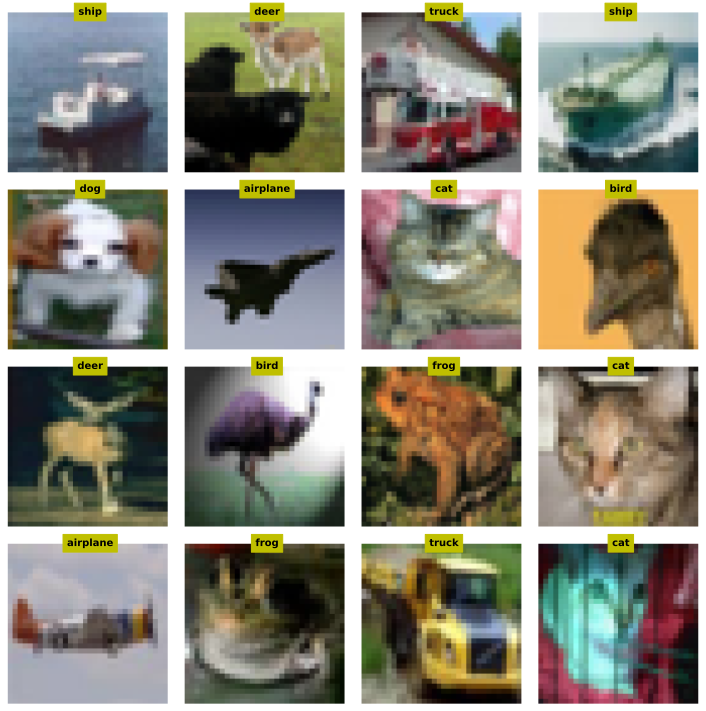

In [4]:
X,y = next(iter(train_loader))

fig,axs = plt.subplots(4,4,figsize=(10,10))

for (i,ax) in enumerate(axs.flatten()):

  pic = X[i].numpy().transpose((1,2,0))
  pic = pic/2 + .5 # undo normalization

  # and its label
  label = trainset.classes[y[i]]

  # and show!
  ax.imshow(pic)
  ax.text(16,0,label,ha='center',fontweight='bold',color='k',backgroundcolor='y')
  # ha is horizontal alignment

  ax.axis('off')

plt.tight_layout()
plt.show()

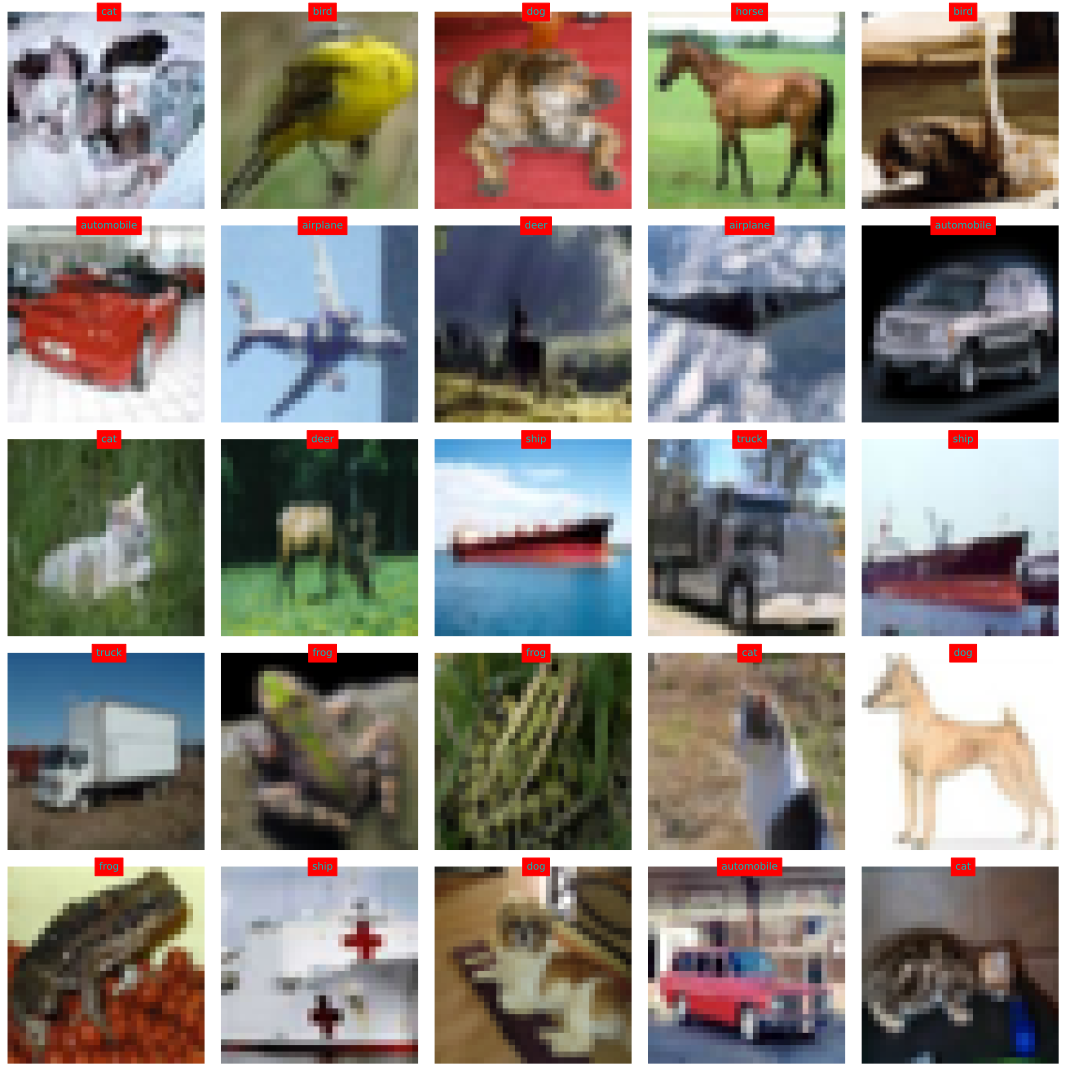

In [5]:
# part1
X1,y1=next(iter(train_loader))

fig,axs=plt.subplots(5,5,figsize=(15,15))

for i,ax in enumerate(axs.flatten()):


  pic=X1[i].data.numpy().transpose((1,2,0))
  pic=pic/2+.5
  ax.imshow(pic)
  ax.axis('off')
  ax.text(16,0,trainset.classes[y1[i]],color='c',backgroundcolor='r',ha='center')


plt.tight_layout()
plt.show()

In [6]:
def makeTheNet():

  class cnnnet(nn.Module):
    def __init__(self):
      super().__init__()


      self.conv1  = nn.Conv2d(3,64,3,padding=1)
      self.bnorm1 = nn.BatchNorm2d(64)
      # input the number of channels in this layer
      # output size: (32+2*1-3)/1 + 1 = 32/2 = 16 (/2 b/c maxpool)

      self.conv2  = nn.Conv2d(64,128,3)
      self.bnorm2 = nn.BatchNorm2d(128)
      # input the number of channels in this layer
      # output size: (16+2*0-3)/1 + 1 = 14/2 = 7 (/2 b/c maxpool)

      self.conv3  = nn.Conv2d(128,256,3)
      self.bnorm3 = nn.BatchNorm2d(256)
      # input the number of channels in this layer
      # output size: (7+2*0-3)/1 + 1 = 5/2 = 2 (/2 b/c maxpool)

      self.fc1 = nn.Linear(2*2*256,256)
      self.fc2 = nn.Linear(256,64)
      self.fc3 = nn.Linear(64,10)

    def forward(self,x):


      x = F.max_pool2d(self.conv1(x),2)
      x = F.leaky_relu(self.bnorm1(x))

      x = F.max_pool2d(self.conv2(x),2)
      x = F.leaky_relu(self.bnorm2(x))

      x = F.max_pool2d(self.conv3(x),2)
      x = F.leaky_relu(self.bnorm3(x))

      nUnits = x.shape.numel()/x.shape[0]
      x = x.view(-1,int(nUnits))

      x = F.leaky_relu(self.fc1(x))
      x = F.dropout(x,p=.5,training=self.training)
      x = F.leaky_relu(self.fc2(x))
      x = F.dropout(x,p=.5,training=self.training)
      # training=self.training means to turn off during eval mode
      x = self.fc3(x)

      return x

  net = cnnnet()

  lossfun = nn.CrossEntropyLoss()


  optimizer = torch.optim.Adam(net.parameters(),lr=.001,weight_decay=1e-5)

  return net,lossfun,optimizer

In [7]:

def funtion2trainTheModel():

  # number of epochs
  numepochs = 10

  net,lossfun,optimizer = makeTheNet()

  net.to(device)

  trainLoss = torch.zeros(numepochs)
  devLoss   = torch.zeros(numepochs)
  trainAcc  = torch.zeros(numepochs)
  devAcc    = torch.zeros(numepochs)


  for epochi in range(numepochs):

    net.train()
    batchLoss = []
    batchAcc  = []
    for X,y in train_loader:

      X = X.to(device)
      y = y.to(device)

      yHat = net(X)
      loss = lossfun(yHat,y)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      batchLoss.append(loss.item())
      batchAcc.append( torch.mean((torch.argmax(yHat,axis=1) == y).float()).item() )

    trainLoss[epochi] = np.mean(batchLoss)
    trainAcc[epochi]  = 100*np.mean(batchAcc)


    net.eval()
    batchAcc  = []
    batchLoss = []
    for X,y in dev_loader:

      X = X.to(device)
      y = y.to(device)

      with torch.no_grad():
        yHat = net(X)
        loss = lossfun(yHat,y)

      batchLoss.append(loss.item())
      batchAcc.append( torch.mean((torch.argmax(yHat,axis=1) == y).float()).item() )

    devLoss[epochi] = np.mean(batchLoss)
    devAcc[epochi]  = 100*np.mean(batchAcc)


  return trainLoss,devLoss,trainAcc,devAcc,net

In [8]:
# test the model with one batch
net,lossfun,optimizer = makeTheNet()

X,y = next(iter(train_loader))
yHat = net(X)

# check size of output
print('\nOutput size:')
print(yHat.shape)

# now compute the loss
loss = lossfun(yHat,torch.squeeze(y))
print(' ')
print('Loss:')
print(loss)


Output size:
torch.Size([32, 10])
 
Loss:
tensor(2.2923, grad_fn=<NllLossBackward0>)


In [9]:
trainLoss,devLoss,trainAcc,devAcc,net = funtion2trainTheModel()

net.eval() # switch to test mode
X,y = next(iter(test_loader))

# push data to GPU
X = X.to(device)
y = y.to(device)

# forward pass and loss
with torch.no_grad():
  yHat = net(X)
  loss = lossfun(yHat,y)

# loss and accuracy from this batch
testLoss = loss.item()
testAcc  = 100*torch.mean((torch.argmax(yHat,axis=1) == y).float()).item()

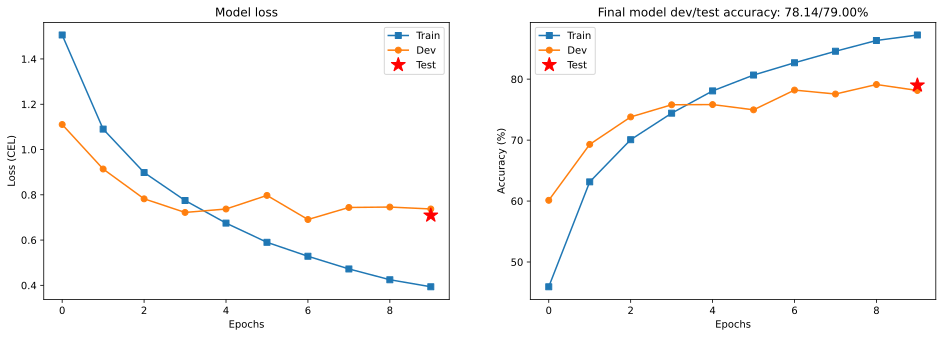

In [14]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(trainLoss,'s-',label='Train')
ax[0].plot(devLoss,'o-',label='Dev')
ax[0].plot(len(devLoss)-1,testLoss,'r*',markersize=15,label='Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss (CEL)')
ax[0].set_title('Model loss')
ax[0].legend()
ax[1].plot(trainAcc,'s-',label='Train')
ax[1].plot(devAcc,'o-',label='Dev')
ax[1].plot(len(devAcc)-1,testAcc,'r*',markersize=15,label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model dev/test accuracy: {devAcc[-1]:.2f}/{testAcc:.2f}%')
ax[1].legend()

plt.show()

In [12]:
print(yHat.shape)
# 4000 *10
print(y.shape)
# 4000
print(torch.argmax(yHat,dim=1).shape)
# 4000

torch.Size([4000, 10])
torch.Size([4000])
torch.Size([4000])
